### Delayed rewards for bandit algorithms
Literature on bandit algorithms frequently does not take into account that rewards are not observed instantly. In this notebook, we demonstrate the impact of this delayed feedback on known bandit algorithms using a simulation.

The simulation works by sampling delay from an exponential distribution as described by *Ktena, Sofia Ira, et al.*[1]. In future experiments it would also be interesting to prior the distribution with the values in context $c$.
This delay is expressed in $d_i$ representing the amount of rounds the algorithm has to wait before being allowed to observe the reward.

Key assumptions
- Delay is independent of the context, action and reward. In real-world applications there might be a connection between these.
- Feedback is never received in the same round as the prediction that is being made. In high volume traffic, it's highly unlikely that a user is able to respond to an action before the next user requests a prediction.

Open questions:
- Should the model be aware of the delay it took for getting the reward?
- What is the default behaviour when actions are taken but rewards are not available yet?

[1] [Ktena, Sofia Ira, et al. "Addressing delayed feedback for continuous training with neural networks in CTR prediction." Proceedings of the 13th ACM conference on recommender systems. 2019.](https://arxiv.org/pdf/1907.06558.pdf)

In [1]:
import copy
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns

from obp.simulator.coefficient_drifter import CoefficientDrifter
from obp.simulator.delay_sampler import ExponentialDelaySampler
from obp.simulator.simulator import BanditEnvironmentSimulator, BanditPolicySimulator

from obp.policy.offline import IPWLearner
from obp.dataset import logistic_sparse_reward_function
from obp.policy import Random, EpsilonGreedy


In [3]:
experiment_round_size = np.arange(start=1000, stop=20001, step=100).tolist()

n_runs_per_round_size = 1000
max_scale = 1000.0
min_scale = 900.0
n_actions = 4
dim_context = 5
reward_func = partial(logistic_sparse_reward_function, z_score=False)

bandit_policies = [
    (Random, {"n_actions": n_actions, "epsilon": 1.0, "random_state": 12345}),
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.1, "random_state": 12345}),
]

dummy_policies = [policy_class(**args) for policy_class, args in bandit_policies]
train_rewards = [{policy.policy_name + f" {type} delay": [] for policy in dummy_policies} for type in ["no", "RI", "RD"]]
train_rewards = {k: v for d in train_rewards for k, v in d.items()}
eval_rewards = {**copy.deepcopy(train_rewards), **{IPWLearner.__name__: []}}
train_rewards["n_rounds"] = []
eval_rewards["n_rounds"] = []



### Get reward dependent delays & no delay data

In [30]:
%%time

delay_function = ExponentialDelaySampler(min_scale=min_scale, max_scale=max_scale, random_state=12345).exponential_delay_function_expected_reward_weighted


for experiment in range(n_runs_per_round_size):
    env = BanditEnvironmentSimulator(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary", # "binary" or "continuous"
        reward_function=reward_func,
        delay_function=delay_function,
        random_state=12345 + experiment,
    )
    sample_n_rounds = max(experiment_round_size)
    training_bandit_batch = env.next_bandit_round_batch(n_rounds=sample_n_rounds)

    # print((np.arange(0, len(training_bandit_dataset["round_delays"])) + training_bandit_dataset["round_delays"] < sample_n_rounds).sum())
    # Train the bandit algorithms and get the rewards for the training and evaluation period
    # Take into account all the delays during training
    for policy_class, args in bandit_policies:
        policy = policy_class(**args)
        training_simulator = BanditPolicySimulator(policy=policy)
        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)

        for n_rounds in experiment_round_size:
            train_rewards[policy.policy_name + " RD delay"].append(np.sum(training_simulator.obtained_rewards[:n_rounds]))

    # Train the bandit algorithms and get the rewards for the training and evaluation period
    # Ignore delays during training
    training_bandit_batch.round_delays = None
    for policy_class, args in bandit_policies:
        policy = policy_class(**args)
        training_simulator = BanditPolicySimulator(policy=policy)
        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)

        for n_rounds in experiment_round_size:
            train_rewards[policy.policy_name + " no delay"].append(np.sum(training_simulator.obtained_rewards[:n_rounds]))

    for n_rounds in experiment_round_size:
        train_rewards["n_rounds"].append(n_rounds)

100%|██████████| 20000/20000 [00:00<00:00, 46417.42it/s]

CPU times: user 1h 27min 19s, sys: 21min 27s, total: 1h 48min 46s
Wall time: 1h 18min 41s


In [31]:
%%time

for experiment in range(n_runs_per_round_size):
    delay_function = ExponentialDelaySampler(max_scale=max_scale, random_state=12345).exponential_delay_function

    env = BanditEnvironmentSimulator(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary", # "binary" or "continuous"
        reward_function=reward_func,
        delay_function=delay_function,
        random_state=12345 + experiment,
    )

    sample_n_rounds = max(experiment_round_size)
    training_bandit_batch = env.next_bandit_round_batch(n_rounds=sample_n_rounds)

    # Train the bandit algorithms and get the rewards for the training and evaluation period
    # Take into account all the delays during training
    for policy_class, args in bandit_policies:
        policy = policy_class(**args)
        training_simulator = BanditPolicySimulator(policy=policy)
        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)

        for n_rounds in experiment_round_size:
            train_rewards[policy.policy_name + " RI delay"].append(np.sum(training_simulator.obtained_rewards[:n_rounds]))


100%|██████████| 20000/20000 [00:01<00:00, 11405.25it/s]

CPU times: user 1h 12min 4s, sys: 22min 2s, total: 1h 34min 6s
Wall time: 1h 3min 41s


In [43]:
def plot_average_reward_per_n_rounds(rewards):
    rewards_pd = pd.DataFrame(rewards)
    rewards_pd = pd.melt(rewards_pd, ['n_rounds'])
    rewards_pd["average reward"] = rewards_pd["value"] / rewards_pd["n_rounds"]

    plot = sns.lineplot(data=rewards_pd, x="n_rounds", y="average reward", style="variable", hue="variable", markers=True, dashes=False)
    plot.legend(bbox_to_anchor=(1.1, 1.05))

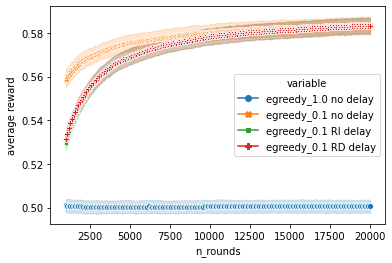

In [44]:
del train_rewards["egreedy_1.0 RD delay"]
del train_rewards["egreedy_1.0 RI delay"]

plot_average_reward_per_n_rounds(train_rewards)

### Delay under constant drift

In [53]:
experiment_round_size = np.arange(start=1000, stop=20001, step=100).tolist()

n_runs_per_round_size = 10000
max_scale = 5000.0
n_actions = 4
dim_context = 5
reward_func = partial(logistic_sparse_reward_function, z_score=False)

bandit_policies = [
    (Random, {"n_actions": n_actions, "epsilon": 1.0, "random_state": 12345}),
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.1, "random_state": 12345}),
]

dummy_policies = [policy_class(**args) for policy_class, args in bandit_policies]
train_rewards = [{policy.policy_name + f" {type} delay": [] for policy in dummy_policies} for type in ["drift + no", "drift +", "no drift +"]]
train_rewards = {k: v for d in train_rewards for k, v in d.items()}
eval_rewards = {**copy.deepcopy(train_rewards), **{IPWLearner.__name__: []}}
train_rewards["n_rounds"] = []
eval_rewards["n_rounds"] = []


In [54]:
%%time
%%capture

delay_function = ExponentialDelaySampler(min_scale=min_scale, max_scale=max_scale, random_state=12345).exponential_delay_function


for experiment in range(n_runs_per_round_size):
    drifter = CoefficientDrifter(
        drift_interval=5000,
        transition_period=100,
        transition_type="weighted_sampled",  # linear or weighted_sampled
        seasonal=True,
        base_coefficient_weight=.3,
        random_state=1234 + experiment,
    )

    env = BanditEnvironmentSimulator(
        n_actions=n_actions,
        dim_context=dim_context,
        coef_function=drifter.get_coefficients,
        reward_function=reward_func,
        delay_function=delay_function,
        random_state=12345 + experiment,
    )

    sample_n_rounds = max(experiment_round_size)
    training_bandit_batch = env.next_bandit_round_batch(n_rounds=sample_n_rounds)

    # Train the bandit algorithms and get the rewards for the training and evaluation period
    # Take into account all the delays during training
    for policy_class, args in bandit_policies:
        policy = policy_class(**args)
        training_simulator = BanditPolicySimulator(policy=policy)
        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)

        for n_rounds in experiment_round_size:
            train_rewards[policy.policy_name + " drift + delay"].append(np.sum(training_simulator.obtained_rewards[:n_rounds]))

    # Train the bandit algorithms and get the rewards for the training and evaluation period
    # Ignore delays during training
    training_bandit_batch.round_delays = None
    for policy_class, args in bandit_policies:
        policy = policy_class(**args)
        training_simulator = BanditPolicySimulator(policy=policy)
        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)

        for n_rounds in experiment_round_size:
            train_rewards[policy.policy_name + " drift + no delay"].append(np.sum(training_simulator.obtained_rewards[:n_rounds]))

    env = BanditEnvironmentSimulator(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_function=reward_func,
        delay_function=delay_function,
        random_state=12345 + experiment,
    )

    sample_n_rounds = max(experiment_round_size)
    training_bandit_batch = env.next_bandit_round_batch(n_rounds=sample_n_rounds)

    for policy_class, args in bandit_policies:
        policy = policy_class(**args)
        training_simulator = BanditPolicySimulator(policy=policy)
        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)

        for n_rounds in experiment_round_size:
            train_rewards[policy.policy_name + " no drift + delay"].append(np.sum(training_simulator.obtained_rewards[:n_rounds]))


    for n_rounds in experiment_round_size:
        train_rewards["n_rounds"].append(n_rounds)

CPU times: user 7h 49min 13s, sys: 7h 53min 49s, total: 15h 43min 2s
Wall time: 5h 54min 35s


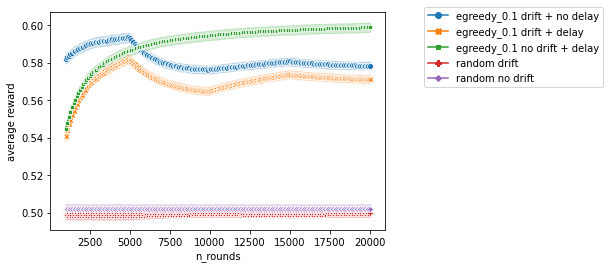

In [57]:
del train_rewards["egreedy_1.0 drift + delay"]
train_rewards["random drift"] = train_rewards.pop("egreedy_1.0 drift + no delay")
train_rewards["random no drift"] = train_rewards.pop("egreedy_1.0 no drift + delay")

plot_average_reward_per_n_rounds(train_rewards)
